EDA TRM 

In [1]:
import pandas as pd
from azure.data.tables import TableClient
import os
from dotenv import load_dotenv, find_dotenv
import matplotlib as plot
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
connection_string = os.getenv("AZ_CONNECTION_STRING")

Funciones necesarias

In [4]:
## Definiendo funciones:


# Crear conexión de una tabla específica dentro del servicio de Azure Table Storage
def set_table_service(connection_string, table):
    """Crear servicio de conexión a Azure Table Storage"""
    return TableClient.from_connection_string(
        conn_str=connection_string, table_name=table
    )


# Obtener datos de Table Storage
def get_data_from_table_storage_table(table_service, filter_query):
    """Recuperar datos de Table Storage"""
    for record in table_service.query_entities(filter_query):
        yield record


# Crear DataFrame con los datos de la tabla consultada
def get_dataframe_from_table_storage_table(table_service, filter_query):
    """Crear un DataFrame con la data del Table Storage"""
    return pd.DataFrame(get_data_from_table_storage_table(table_service, filter_query))

In [5]:
table_name_trm = "TRMCurated"
filterQuery = "PartitionKey ne 'random'"

In [6]:
# Creando DataFrame con TRM Data
table_service_trm = set_table_service(connection_string, table_name_trm)
df_trm = get_dataframe_from_table_storage_table(table_service_trm, filterQuery)

print(f"Shape: {df_trm.shape}")
print(f"dtypes: {df_trm.dtypes}")
df_trm.head()

Shape: (689, 5)
dtypes: PartitionKey      object
RowKey            object
valor            float64
vigenciadesde     object
vigenciahasta     object
dtype: object


,PartitionKey,RowKey,valor,vigenciadesde,vigenciahasta
0,TRM_20210101_20231020.csv,2021-01-05T00:00:00.000,3420.78,2021-01-05T00:00:00.000,2021-01-05T00:00:00.000
1,TRM_20210101_20231020.csv,2021-01-06T00:00:00.000,3450.74,2021-01-06T00:00:00.000,2021-01-06T00:00:00.000
2,TRM_20210101_20231020.csv,2021-01-07T00:00:00.000,3428.04,2021-01-07T00:00:00.000,2021-01-07T00:00:00.000
3,TRM_20210101_20231020.csv,2021-01-08T00:00:00.000,3459.39,2021-01-08T00:00:00.000,2021-01-08T00:00:00.000
4,TRM_20210101_20231020.csv,2021-01-09T00:00:00.000,3478.11,2021-01-09T00:00:00.000,2021-01-12T00:00:00.000


In [7]:
conteo_por_grupo = df_trm.groupby(['vigenciadesde']).size().reset_index(name='Conteo')

# Muestra los grupos que tienen más de un registro (si hay alguno)
duplicados = conteo_por_grupo[conteo_por_grupo['Conteo'] > 1]

In [8]:
duplicados.head()

,vigenciadesde,Conteo
666,2023-10-24T00:00:00.000,2
675,2023-11-04T00:00:00.000,2


In [9]:
duplicados = df_trm[df_trm.duplicated()]

# Si hay registros duplicados, verifica que todos tengan el mismo valor en 'Valor'
for indice, grupo in duplicados.groupby(['vigenciadesde', 'vigenciahasta']):
    if grupo['Valor'].nunique() > 1:
        print(f"Registros duplicados con diferentes valores en 'Valor' para Departamento {indice[0]} y Fecha {indice[1]}:")
        print(grupo)

#todos los registros duplicados tienen el mismo valor

In [10]:
# Borramos los duplicados que TRM

df_sin_duplicados = df_trm.drop_duplicates(subset=['valor', 'vigenciadesde','vigenciahasta'])

# Imprime el DataFrame resultante
print(f"Shape: {df_sin_duplicados.shape}")
print(f"dtypes: {df_sin_duplicados.dtypes}")
df_sin_duplicados.head()

Shape: (687, 5)
dtypes: PartitionKey      object
RowKey            object
valor            float64
vigenciadesde     object
vigenciahasta     object
dtype: object


,PartitionKey,RowKey,valor,vigenciadesde,vigenciahasta
0,TRM_20210101_20231020.csv,2021-01-05T00:00:00.000,3420.78,2021-01-05T00:00:00.000,2021-01-05T00:00:00.000
1,TRM_20210101_20231020.csv,2021-01-06T00:00:00.000,3450.74,2021-01-06T00:00:00.000,2021-01-06T00:00:00.000
2,TRM_20210101_20231020.csv,2021-01-07T00:00:00.000,3428.04,2021-01-07T00:00:00.000,2021-01-07T00:00:00.000
3,TRM_20210101_20231020.csv,2021-01-08T00:00:00.000,3459.39,2021-01-08T00:00:00.000,2021-01-08T00:00:00.000
4,TRM_20210101_20231020.csv,2021-01-09T00:00:00.000,3478.11,2021-01-09T00:00:00.000,2021-01-12T00:00:00.000


In [11]:
# Se organiza la fecha con el formato necesario

df_sin_duplicados_fecha = df_sin_duplicados.copy()

df_sin_duplicados_fecha['vigenciadesde'] = pd.to_datetime(df_sin_duplicados_fecha['vigenciadesde'], errors='coerce')
df_sin_duplicados_fecha['vigenciadesde'] = df_sin_duplicados_fecha['vigenciadesde'].dt.strftime('%Y-%m-%d')
df_sin_duplicados_fecha['vigenciahasta'] = pd.to_datetime(df_sin_duplicados_fecha['vigenciahasta'], errors='coerce')
df_sin_duplicados_fecha['vigenciahasta'] = df_sin_duplicados_fecha['vigenciahasta'].dt.strftime('%Y-%m-%d')

print(f"Shape: {df_sin_duplicados_fecha.shape}")
print(f"dtypes: {df_sin_duplicados_fecha.dtypes}")
df_sin_duplicados_fecha

Shape: (687, 5)
dtypes: PartitionKey      object
RowKey            object
valor            float64
vigenciadesde     object
vigenciahasta     object
dtype: object


,PartitionKey,RowKey,valor,vigenciadesde,vigenciahasta
0,TRM_20210101_20231020.csv,2021-01-05T00:00:00.000,3420.78,2021-01-05,2021-01-05
1,TRM_20210101_20231020.csv,2021-01-06T00:00:00.000,3450.74,2021-01-06,2021-01-06
2,TRM_20210101_20231020.csv,2021-01-07T00:00:00.000,3428.04,2021-01-07,2021-01-07
3,TRM_20210101_20231020.csv,2021-01-08T00:00:00.000,3459.39,2021-01-08,2021-01-08
4,TRM_20210101_20231020.csv,2021-01-09T00:00:00.000,3478.11,2021-01-09,2021-01-12
...,...,...,...,...,...
684,TRM_20231117.csv,2023-11-17T00:00:00.000,4077.44,2023-11-17,2023-11-17
685,TRM_20231118.csv,2023-11-18T00:00:00.000,4116.59,2023-11-18,2023-11-20
686,TRM_20231121.csv,2023-11-21T00:00:00.000,4033.83,2023-11-21,2023-11-21
687,TRM_20231122.csv,2023-11-22T00:00:00.000,4060.15,2023-11-22,2023-11-22


In [12]:
df = df_sin_duplicados_fecha[[ "vigenciadesde","valor"]]

In [13]:
df.isnull()

,vigenciadesde,valor
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
684,False,False
685,False,False
686,False,False
687,False,False


In [14]:
# Verifica si hay algún True en la columna vigenciadesde
hay_datos_nulos_vigenciadesde = any(df.isnull()['vigenciadesde'])

# Verifica si hay algún True en la columna valor
hay_datos_nulos_valor = any(df.isnull()['valor'])

print(hay_datos_nulos_vigenciadesde, hay_datos_nulos_valor)


True False


In [15]:
# Obtiene el índice 675
indice_vigenciadesde = 674

# Coloca el valor en el DataFrame
df.loc[indice_vigenciadesde, 'vigenciadesde'] = '2023-11-02'

print(df)

    vigenciadesde    valor
0      2021-01-05  3420.78
1      2021-01-06  3450.74
2      2021-01-07  3428.04
3      2021-01-08  3459.39
4      2021-01-09  3478.11
..            ...      ...
684    2023-11-17  4077.44
685    2023-11-18  4116.59
686    2023-11-21  4033.83
687    2023-11-22  4060.15
688    2023-11-23  4092.33

[687 rows x 2 columns]


In [16]:
print(f"dtypes: {df.dtypes}")

dtypes: vigenciadesde     object
valor            float64
dtype: object


In [17]:
df['vigenciadesde'] = pd.to_datetime(df['vigenciadesde'])

/tmp/ipykernel_21347/2263000391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vigenciadesde'] = pd.to_datetime(df['vigenciadesde'])


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 687 entries, 0 to 688
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   vigenciadesde  687 non-null    datetime64[ns]
 1   valor          687 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 32.3 KB


In [19]:
# Obtiene las estadísticas básicas de los datos
df['valor'].describe()

count     687.000000
mean     4111.860684
std       400.704113
min      3420.780000
25%      3797.600000
50%      3997.740000
75%      4421.760000
max      5061.210000
Name: valor, dtype: float64

<Axes: xlabel='valor', ylabel='Count'>

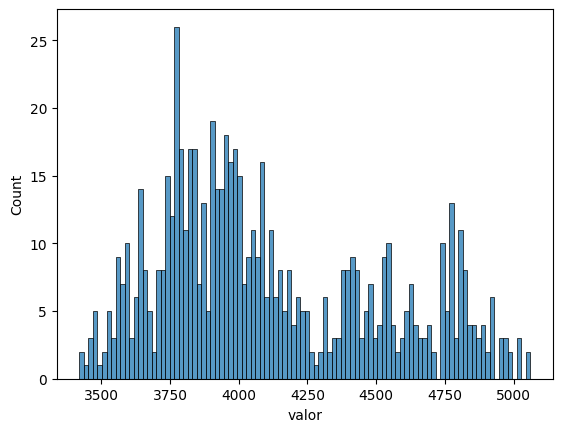

In [20]:
sns.histplot(df['valor'], bins=100, linewidth=0.5)

In [21]:
df['año'] = df['vigenciadesde'].dt.year
df_agrupado = df.groupby('año')
df.groupby('año')['valor'].describe()


/tmp/ipykernel_21347/641108913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['año'] = df['vigenciadesde'].dt.year


,count,mean,std,min,25%,50%,75%,max
año,,,,,,,,
2021,238.0,3749.122437,145.569419,3420.78,3636.4225,3768.46,3854.565,4023.68
2022,238.0,4251.469664,387.652758,3706.95,3934.0425,4140.54,4528.965,5061.21
2023,211.0,4363.542038,310.064941,3898.48,4092.6850,4249.00,4642.560,4989.58


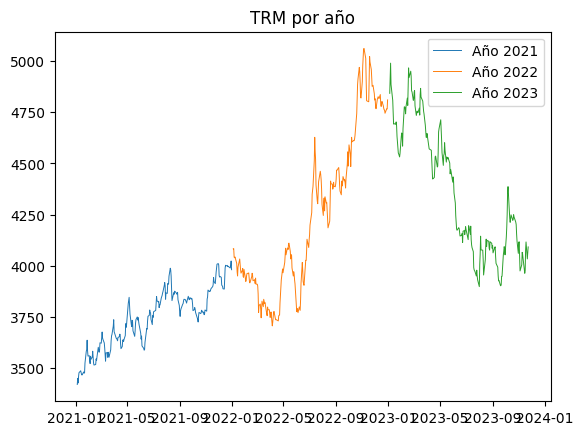

In [22]:
#|Graficar el comportamiento por año

fig, ax = plt.subplots()

for año, data in df_agrupado:
    ax.plot(data['vigenciadesde'], data['valor'], label=f'Año {año}', linewidth=0.7)

ax.set_title('TRM por año')
ax.legend()

plt.show()


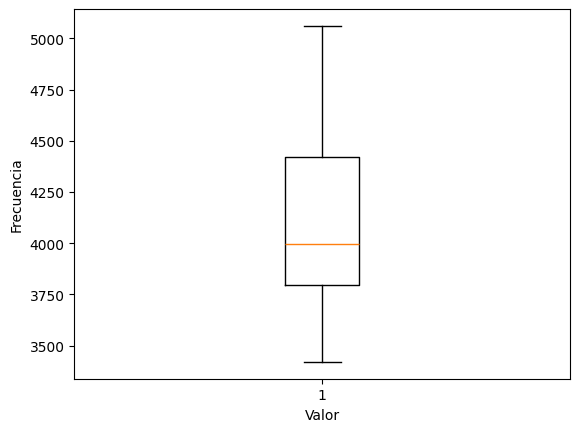

In [23]:
fig, ax = plt.subplots()

ax.boxplot(df['valor'], whis=1.5, showfliers=True)

ax.set_xlabel('Valor')

ax.set_ylabel('Frecuencia')

ax.annotate('Valor atípico', (df['valor'].min(), 0.5))

plt.show()


In [39]:
TRM = df[[ "vigenciadesde","valor"]]


In [40]:
# Establecer la ruta del archivo CSV
ruta_archivo = "/home/jsavilaarias/Proyecto-Integrador-Semestre1/python-notebooks/processed_tables/TRM.csv"

# Guardar el DataFrame en el archivo CSV
TRM.to_csv(ruta_archivo)